# 2D Flow Matching in JAX

This notebook implements flow matching on a 2D checkerboard dataset using an affine probability path $x_t = (1-t) \cdot x_0 + t \cdot x_1$ with $x_0 \sim \mathcal{N}(0, I)$. An MLP learns the velocity field $v_\theta(x, t)$ for ODE-based sampling and likelihood estimation via Hutchinson's trace estimator.

## Imports

In [ ]:
import time
from collections.abc import Generator
from functools import partial
from typing import Any

import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import Array, Float, PRNGKeyArray
from lightning import LightningModule, Trainer
from matplotlib import cm
from torch.utils.data import DataLoader, IterableDataset


In [ ]:
# Only needed in Google Colab
%pip install diffrax equinox jaxtyping lightning torch

## Dataset

In [ ]:
class CheckerboardDataset(IterableDataset):
    """Iterable dataset for generating checkerboard pattern."""

    def __init__(self, batch_size: int = 200, seed: int = 42) -> None:
        """Initialize the checkerboard iterable dataset.

        Args:
            batch_size: Number of samples to generate per batch.
            seed: Random seed for reproducibility.
        """
        self.batch_size = batch_size
        self.key = jr.PRNGKey(seed)

    @eqx.filter_jit
    def generate_checkerboard_data(self, key: PRNGKeyArray, batch_size: int = 200) -> Float[Array, "batch_size 2"]:
        """Generate checkerboard dataset samples.

        Args:
            key: JAX random key for sampling.
            batch_size: Number of samples to generate.

        Returns:
            Array of 2D checkerboard pattern samples.
        """
        key1, key2, key3 = jr.split(key, 3)

        x1 = jr.uniform(key1, (batch_size,)) * 4 - 2
        x2_ = jr.uniform(key2, (batch_size,)) - jr.randint(key3, (batch_size,), 0, 2) * 2
        x2 = x2_ + (jnp.floor(x1) % 2)

        data = jnp.stack([x1, x2], axis=1) / 0.45
        return data.astype(jnp.float32)

    def __iter__(self) -> Generator:
        """Create an iterator that generates batches."""
        while True:
            self.key, subkey = jr.split(self.key)
            batch = self.generate_checkerboard_data(subkey, self.batch_size)
            yield batch

## Model

In [18]:
class MLP(eqx.Module):
    """Multi-layer perceptron for velocity field prediction."""

    mlp: eqx.nn.MLP

    def __init__(
        self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128, depth: int = 5, *, key: PRNGKeyArray
    ) -> None:
        """Initialize MLP for velocity field prediction.

        Args:
            input_dim: Dimensionality of input space.
            time_dim: Dimensionality of time encoding.
            hidden_dim: Width of hidden layers.
            depth: Number of hidden layers.
            key: JAX random key for parameter initialization.
        """
        super().__init__()
        self.mlp = eqx.nn.MLP(
            in_size=input_dim + time_dim,
            out_size=input_dim,
            width_size=hidden_dim,
            depth=depth,
            activation=jax.nn.silu,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x: Float[Array, " dim"], t: Float[Array, ""]) -> Float[Array, " dim"]:
        """Forward pass through the MLP.

        Args:
            x: Input spatial coordinates.
            t: Time values.

        Returns:
            Predicted velocity field at (x, t).
        """
        t = jnp.atleast_1d(t)
        h = jnp.concatenate([x, t])
        return self.mlp(h)


## Flow matching trainer and sampler

In [ ]:
class FlowMatching(LightningModule):
    """Flow matching trainer with integrated sampling and likelihood computation."""

    def __init__(
        self,
        backbone: Any,
        learning_rate: float = 1e-4,
        step_size: float = 0.05,
        guidance: float = 2.0,
        b1: float = 0.9,
        b2: float = 0.995,
        weight_decay: float = 1e-5,
        *,
        key: PRNGKeyArray,
    ) -> None:
        """Initialize flow matching trainer.

        Args:
            backbone: Velocity field model to train.
            learning_rate: Learning rate for optimization.
            step_size: Initial step size for ODE solver.
            guidance: Classifier-free guidance weight.
            b1: AdamW beta 1 hyperparameter.
            b2: AdamW beta 2 hyperparameter.
            weight_decay: Weight decay hyperparameter.
            key: JAX random key for initialization.
        """
        super().__init__()
        self.automatic_optimization = False
        self.model = backbone
        self.learning_rate = learning_rate
        self.step_size = step_size
        self.guidance = guidance
        self.b1 = b1
        self.b2 = b2
        self.weight_decay = weight_decay
        self.key, self.train_key, self.sample_key = jr.split(key, num=3)

    def training_step(self, batch: dict[str, Float[Array, " batch_size ..."]]) -> Array:
        """Execute single training step with flow matching loss.

        Args:
            batch: Training batch of data points.

        Returns:
            Training loss value.
        """
        self.model = eqx.nn.inference_mode(self.model, value=False)
        loss, self.model, self.opt_state, self.train_key = FlowMatching.make_step(
            self.model, batch, self.train_key, self.opt_state, self.optimizer
        )
        self.log_dict({"train_loss": loss.item()}, batch_size=1, prog_bar=True, on_epoch=True, on_step=False)

    def validation_step(self, batch: dict[str, Float[Array, " batch_size ..."]]) -> None:
        """Execute single validation step with flow matching loss.

        Args:
            batch: Validation batch of data points.
        """
        self.model = eqx.nn.inference_mode(self.model, value=True)
        loss, self.model, self.opt_state, self.train_key = FlowMatching.make_step(
            self.model, batch, self.train_key, self.opt_state, self.optimizer
        )
        self.log_dict({"val_loss": loss.item()}, batch_size=1, prog_bar=True, on_epoch=True, on_step=False)

    def configure_optimizers(self) -> None:
        """Configure AdamW optimizer and initialize optimizer state."""
        self.optimizer = optax.adamw(self.learning_rate, b1=self.b1, b2=self.b2, weight_decay=self.weight_decay)
        self.opt_state = self.optimizer.init(eqx.filter(self.model, eqx.is_array))

    @staticmethod
    def loss_fn(
        model: eqx.Module,
        batch: Float[Array, " batch_size ..."],
        key: PRNGKeyArray,
    ) -> Float[Array, " 1"]:
        """Compute vectorized flow matching loss across a batch of data points.

        Args:
            model: Velocity field neural network model.
            batch: Batch of data points.
            key: Random key for sampling, split across batch dimension.

        Returns:
            Mean loss across the batch.
        """
        x = batch

        key, noise_key, time_key = jr.split(key, num=3)

        x_0 = jr.normal(key=noise_key, shape=x.shape)
        t = jr.uniform(key=time_key, shape=(x.shape[0], 1))

        x_t = (1 - t) * x_0 + t * x
        dx_t = x - x_0

        predicted_velocity = jax.vmap(model)(x_t, t)
        loss = jnp.mean((predicted_velocity - dx_t) ** 2)
        return loss

    @staticmethod
    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        batch: Float[Array, " batch_size ..."],
        key: PRNGKeyArray,
        opt_state: optax.OptState,
        optimizer: optax.GradientTransformation,
    ) -> tuple[Array, eqx.Module, optax.OptState, PRNGKeyArray]:
        """Perform one optimization step using computed gradients.

        JIT-compiled function that computes loss and gradients, applies optimizer
        updates, and returns updated model state.

        Args:
            model: Current velocity field model parameters.
            batch: Training batch of target data points.
            key: Random key for loss computation.
            opt_state: Current optimizer state.
            optimizer: Optax optimizer transformation.

        Returns:
            Tuple of (loss, updated_model, updated_opt_state, new_key).
        """
        key, new_key = jr.split(key)
        loss_fn = eqx.filter_value_and_grad(FlowMatching.loss_fn)
        loss, grads = loss_fn(model, batch, key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state, new_key

    @staticmethod
    @eqx.filter_jit
    def sample(
        model: eqx.Module,
        noise_shape: tuple,
        step_size: float,
        key: PRNGKeyArray,
        time_grid: Float[Array, " time_steps"] | None = None,
    ) -> Float[Array, "time_steps batch_size ..."] | Float[Array, "batch_size ..."]:
        """Sample trajectories using diffrax ODE solver.

        Args:
            model: Velocity field model to integrate.
            noise_shape: Shape of the input noise.
            step_size: Initial step size.
            key: Random key.
            time_grid: Time points for integration. If none, the last time will be returned.

        Returns:
            Final points or full trajectory depending on return_intermediates.
        """
        x_init = jr.normal(key, noise_shape)

        def vector_field(t: float, x: Float[Array, "batch_size ..."], args: tuple) -> Float[Array, "batch_size ..."]:  # noqa: ARG001
            t = jnp.array(t)
            model_t = jax.vmap(partial(model, t=t))
            return model_t(x)

        solution = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(vector_field),
            solver=diffrax.Dopri5(),
            t0=0.0,
            t1=1.0,
            dt0=step_size,
            y0=x_init,
            saveat=diffrax.SaveAt(ts=time_grid) if time_grid is not None else diffrax.SaveAt(t1=True),
        )

        return solution.ys.squeeze() if time_grid is None else solution.ys

    @staticmethod
    @eqx.filter_jit
    def _hutchinson_logp_wrapper(
        t: float, y: tuple[Float[Array, "batch_size dim"], Float[Array, " batch_size"]], args: tuple
    ) -> tuple[Float[Array, "batch_size dim"], Float[Array, " batch_size"]]:
        """Hutchinson's trace estimator wrapper for computing log-density change.

        Args:
            t: Current time.
            y: Tuple of (positions, log_density_change).
            args: Additional arguments including random vectors and velocity model.

        Returns:
            Tuple of (velocity_field, trace_estimate).
        """
        y, _ = y
        eps, velocity_model = args

        def fn(y_inner: Float[Array, "batch_size dim"]) -> Float[Array, "batch_size dim"]:
            return jax.vmap(partial(velocity_model, t=jnp.array(t).reshape((1,))))(y_inner)

        f, vjp_fn = jax.vjp(fn, y)
        (eps_dfdy,) = vjp_fn(eps)
        logp = jnp.sum(eps_dfdy * eps, axis=1)
        return f, logp

    @eqx.filter_jit
    def compute_log_likelihood(
        self, x_data: Float[Array, "batch_size dim"], key: PRNGKeyArray
    ) -> Float[Array, " batch_size"]:
        """Compute log-likelihood using Hutchinson's estimator.

        Args:
            x_data: Data points to evaluate likelihood at.
            key: Random key for Hutchinson estimator.

        Returns:
            Log-likelihood estimates for each data point.
        """
        batch_size = x_data.shape[0]

        eps = jr.rademacher(key, x_data.shape, dtype=x_data.dtype)
        delta_log_likelihood = jnp.zeros(batch_size)

        solution = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(self._hutchinson_logp_wrapper),
            solver=diffrax.Dopri5(),
            t0=1.0,
            t1=0.0,
            dt0=-self.step_size,
            y0=(x_data, delta_log_likelihood),
            args=(eps, self.model),
        )

        final_x, final_delta_log_p = solution.ys
        final_x = jnp.squeeze(final_x, axis=0)
        final_delta_log_p = jnp.squeeze(final_delta_log_p, axis=0)

        base_log_p = -0.5 * (final_x.shape[1] * jnp.log(2 * jnp.pi) + jnp.sum(final_x**2, axis=1))

        return final_delta_log_p + base_log_p

## Train flow matching model

In [20]:
def train_flow_matching_model() -> FlowMatching:
    """Train a 2D flow matching model on checkerboard data.

    Returns:
        Trained FlowMatching instance.
    """
    key = jr.key(42)
    mlp_key, fm_key = jr.split(key)
    model = MLP(input_dim=2, time_dim=1, hidden_dim=512, key=mlp_key)
    flow_matcher = FlowMatching(backbone=model, learning_rate=0.001, step_size=0.05, key=fm_key)
    data_loader = DataLoader(CheckerboardDataset(batch_size=4096), batch_size=1, collate_fn=lambda x: x[0])

    trainer = Trainer(
        max_epochs=1,
        limit_train_batches=10000,
        enable_checkpointing=False,
        enable_model_summary=False,
    )
    trainer.fit(flow_matcher, data_loader)

    return flow_matcher


model = train_flow_matching_model()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/venv/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
SLURM auto-requeueing enabled. Setting signal handlers.
/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10000/10000 [02:14<00:00, 74.21it/s, v_num=3e+6, train_loss=3.780]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10000/10000 [02:14<00:00, 74.21it/s, v_num=3e+6, train_loss=3.780]


## Visualizing flow path

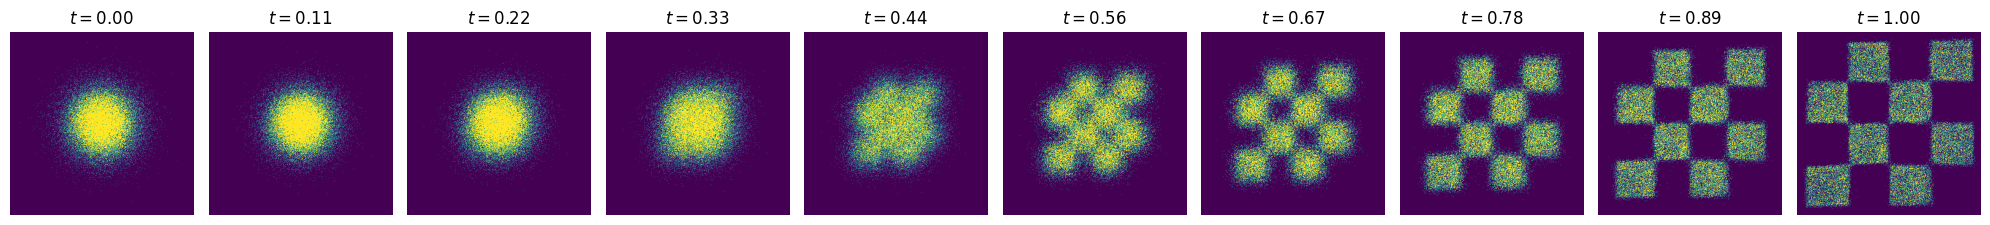

In [21]:
def visualize_flow_path(flow_matcher: FlowMatching, batch_size: int = 50000) -> None:
    """Visualize the flow path evolution over time.

    Args:
        flow_matcher: Trained FlowMatching instance.
        batch_size: Number of trajectories to simulate.
    """
    T = jnp.linspace(0, 1, 10)
    sample_key = jr.key(42)
    trajectory = flow_matcher.sample(
        flow_matcher.model, noise_shape=(batch_size, 2), step_size=0.01, key=sample_key, time_grid=T
    )

    trajectory_np = np.array(trajectory)
    T_np = np.array(T)

    _, axs = plt.subplots(1, 10, figsize=(20, 4))
    axs = axs.flatten()

    for i in range(10):
        H, _, _ = np.histogram2d(trajectory_np[i, :, 0], trajectory_np[i, :, 1], bins=300, range=[[-5, 5], [-5, 5]])
        cmax = np.quantile(H, 0.95)
        norm = cm.colors.Normalize(vmax=cmax, vmin=0)

        axs[i].imshow(H.T, extent=[-5, 5, -5, 5], origin="lower", cmap="viridis", norm=norm)
        axs[i].set_aspect("equal")
        axs[i].axis("off")
        axs[i].set_title(f"$t = {T_np[i]:.2f}$")
        axs[i].set_xlabel("$x_1$")
        axs[i].set_ylabel("$x_2$")

    plt.tight_layout()
    plt.show()


visualize_flow_path(model)

## Visualizing learned likelihood

Computing likelihood with 10 Hutchinson estimates...
Accumulation step 1/10
Accumulation step 2/10
Accumulation step 3/10
Accumulation step 4/10
Accumulation step 5/10
Accumulation step 6/10
Accumulation step 7/10
Accumulation step 8/10
Accumulation step 9/10
Accumulation step 10/10
Likelihood computation completed in 4.33 seconds


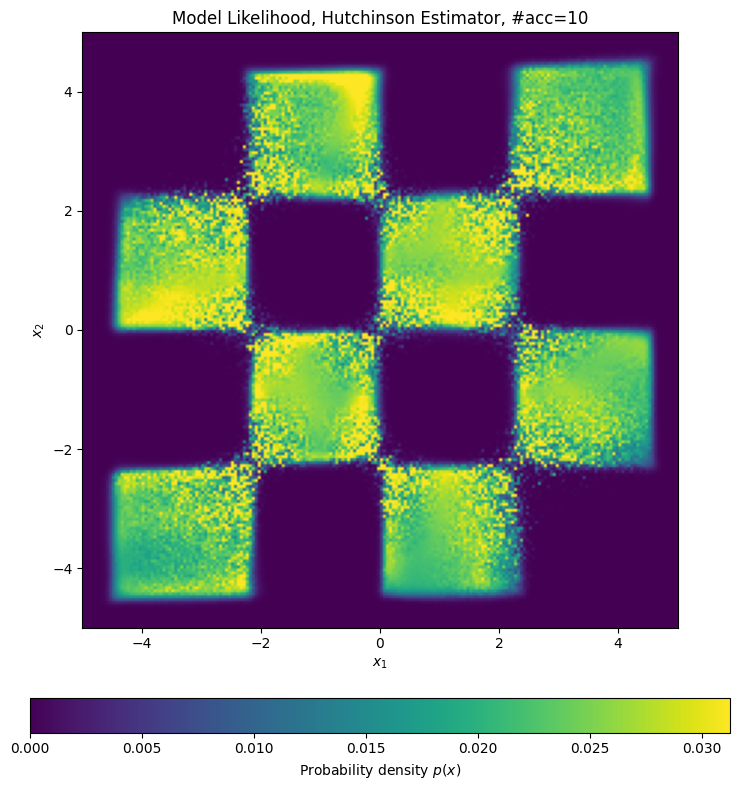

In [23]:
def visualize_likelihood(flow_matcher: FlowMatching, grid_size: int = 200, num_acc: int = 10) -> None:
    """Visualize the learned likelihood using averaged Hutchinson estimator.

    Args:
        flow_matcher: Trained FlowMatching instance.
        grid_size: Resolution of evaluation grid.
        num_acc: Number of Hutchinson estimates to average.
    """
    key = jr.key(42)

    x_range = jnp.linspace(-5, 5, grid_size)
    y_range = jnp.linspace(-5, 5, grid_size)
    X, Y = jnp.meshgrid(x_range, y_range)
    grid_points = jnp.stack([X.flatten(), Y.flatten()], axis=1)

    print(f"Computing likelihood with {num_acc} Hutchinson estimates...")
    start_time = time.time()

    log_p_acc = jnp.zeros(len(grid_points))

    for acc_step in range(num_acc):
        print(f"Accumulation step {acc_step + 1}/{num_acc}")

        key, step_key = jr.split(key)
        batch_log_p = flow_matcher.compute_log_likelihood(grid_points, step_key)
        log_p_acc += batch_log_p

    log_p_acc /= num_acc

    elapsed = time.time() - start_time
    print(f"Likelihood computation completed in {elapsed:.2f} seconds")

    likelihood = jnp.exp(log_p_acc).reshape(grid_size, grid_size)
    likelihood_np = np.array(likelihood)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    cmin = 0.0
    cmax = 1 / 32
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    im = ax.imshow(likelihood_np, extent=(-5, 5, -5, 5), origin="lower", cmap="viridis", norm=norm)
    ax.set_title(f"Model Likelihood, Hutchinson Estimator, #acc={num_acc}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    fig.colorbar(im, ax=ax, orientation="horizontal", label="Probability density $p(x)$", fraction=0.05, pad=0.1)

    plt.tight_layout()
    plt.show()


visualize_likelihood(model)